<a href="https://colab.research.google.com/github/AndreasICL/MSc_Project/blob/master/code/VFF_and_RFF_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow==2.2.0
!pip install gpflow
!pip install gast
!pip install observations
# !git clone https://github.com/markvdw/gpflow-monitor.git
# !cp -r gpflow-monitor/gpflow_monitor .
# !python gpflow-monitor/setup.py develop

In [0]:
from typing import Tuple, Optional
import tempfile
import pathlib

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

import matplotlib.pyplot as plt

from gpflow.config import default_float
from gpflow.ci_utils import ci_niter
from gpflow.utilities import to_default_float
from gpflow.base import TensorLike
from gpflow import covariances as cov
from gpflow import kullback_leiblers as kl
# from gpflow_monitor import *

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import csv
import numpy as np
import os
from shutil import copyfile, rmtree

import observations

import warnings

warnings.filterwarnings("ignore")

Make `tensorboard` work inside notebook:

In [0]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = pathlib.Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Set up random seeds and default float for `gpflow` tensors:

In [0]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading the snelson dataset

In [0]:
'''
  This code was copied from https://github.com/edwardlib/observations/blob/master/observations/snelson1d.py
  on 01/05/2020
'''

from observations.util import maybe_download_and_extract


def snelson1d(path):
  """Load Edward Snelson's 1d regression data set [@snelson2006fitc].
  It contains 200 examples of a few oscillations of an example function. It has
  seen extensive use as a toy dataset for illustrating qualitative behaviour of
  Gaussian process approximations.
  Args:
    path: str.
      Path to directory which either stores file or otherwise file will be
      downloaded and extracted there. Filenames are `snelson_train_*`.
  Returns:
    Tuple of two np.darray `inputs` and `outputs` with 200 rows and 1 column.
  """
  path = os.path.expanduser(path)
  inputs_path = os.path.join(path, 'snelson_train_inputs')
  outputs_path = os.path.join(path, 'snelson_train_outputs')

  # Contains all source as well. We just need the data.
  url = 'http://www.gatsby.ucl.ac.uk/~snelson/SPGP_dist.zip'

  if not (os.path.exists(inputs_path) and os.path.exists(outputs_path)):
    maybe_download_and_extract(path, url)

    # Copy the required data
    copyfile(os.path.join(path, "SPGP_dist", "train_inputs"), inputs_path)
    copyfile(os.path.join(path, "SPGP_dist", "train_outputs"), outputs_path)

    # Clean up everything else
    rmtree(os.path.join(path, "SPGP_dist"))
    os.remove(os.path.join(path, "SPGP_dist.zip"))

  X = np.loadtxt(os.path.join(inputs_path))[:, None]
  Y = np.loadtxt(os.path.join(outputs_path))[:, None]

  return X, Y

In [0]:
X, Y = snelson1d(".")
num_train_data = X.shape[0]

Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data. For `prefetch` size we use `tf.data.experimental.AUTOTUNE` as recommended by TensorFlow [guidelines](https://www.tensorflow.org/guide/data_performance).

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
# test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = tf.data.experimental.AUTOTUNE
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = (
    train_dataset.repeat()
    .prefetch(prefetch_size)
    .shuffle(buffer_size=shuffle_buffer_size)
    .batch(batch_size)
)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=-1
shuffle_buffer_size=100
num_batches_per_epoch=6


## Define a GP model

In GPflow 2.0, we use `tf.Module` (or the very thin `gpflow.base.Module` wrapper) to build all our models, as well as their components (kernels, likelihoods, parameters, and so on).

### 1D Random Variational Fourier Feature Class

In [0]:
class RVFF_1D(gpflow.inducing_variables.InducingVariables):
    def __init__(self, a, b, M):
        omegasVar = 500
        # [a, b] defining the interval of the Fourier representation:
        self.a = gpflow.Parameter(a, dtype=gpflow.default_float())
        self.b = gpflow.Parameter(b, dtype=gpflow.default_float())

        self.phis = np.random.uniform(0, 2 * np.pi, size=M)
        self.omegas = np.random.uniform(0, 200, size=M)#np.random.multivariate_normal( 
        #     mean = np.zeros(M),#2 * np.pi * np.ones( shape=M ) / ( b - a), 
        #     cov = omegasVar * np.identity( M ) 
        # ) 

    def __len__(self):
        """ number of inducing variables (defines dimensionality of q(u)) """ 
        return len(self.omegas)  # M sine components

In [0]:
@cov.Kuu.register(RVFF_1D, gpflow.kernels.Matern12)
def Kuu_matern12_RVFF_1D(inducing_variable, kernel, jitter=None):
    a, b, omegas, phis = (lambda u: (u.a, u.b, u.omegas, u.phis))(inducing_variable)
    
    lambda_ = 1.0 / kernel.lengthscales

    def innerProduct( intervalLen, omegas, phis, kernelVar, lambda_):
      angle1 = intervalLen * ( omegas[:, None] - omegas[None, :] ) + omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle2 = intervalLen * ( omegas[:, None] + omegas[None, :] ) + omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle3 = omegas[:, None] * phis[:, None] - omegas[None, :] * phis[None, :]
      angle4 = omegas[:, None] * phis[:, None] + omegas[None, :] * phis[None, :]
      angle5 = 2 * omegas * ( intervalLen + phis )
      angle6 = 2 * omegas * phis

      coeff1 = ( omegas[:, None] * omegas[None, :] + lambda_ * lambda_ ) / ( omegas[:, None] - omegas[None, :] )
      coeff2 = ( omegas[:, None] * omegas[None, :] - lambda_ * lambda_ ) / ( omegas[:, None] + omegas[None, :] )
      coeff3 = ( omegas * omegas - lambda_ * lambda_ ) / ( 2 * omegas )

      denom = 4 * kernelVar * kernelVar * lambda_

      firstTerm = ( coeff1 * tf.sin( angle1 ) +
                    coeff2 * tf.sin( angle2 ) -
                    lambda_ * tf.cos( angle2 ) +
                    lambda_ * tf.cos( angle1 ) -
                    coeff1 * tf.sin( angle3 ) -
                    coeff2 * tf.sin( angle4 ) +
                    lambda_ * tf.cos( angle4 ) -
                    lambda_ * tf.cos( angle3 ) ) / denom

      mainDiag = ( ( omegas * omegas + lambda_ * lambda_ ) * intervalLen + 
                   coeff3 * tf.sin( angle5 ) -
                   ( lambda_ * tf.cos( angle5 ) ) - 
                   ( coeff3 * tf.sin( angle6 ) ) +
                   lambda_ * tf.cos( angle6 ) ) / denom

      firstTerm = tf.linalg.set_diag( firstTerm, mainDiag )
      secondTerm = tf.sin( omegas[:, None] * phis[:, None] ) * tf.sin( omegas[None, :] * phis[None, :] ) / ( kernelVar * kernelVar )
      
      res = firstTerm + secondTerm
      res = 0.5 * (res + tf.transpose(res))

      if jitter != None:
        res = res + tf.cast(tf.linalg.diag( jitter * tf.ones( res.shape[0] ) ), default_float())

      return res

    return innerProduct( b - a, omegas, phis, kernel.variance, lambda_ )

@cov.Kuf.register(RVFF_1D, gpflow.kernels.Matern12, TensorLike)
def Kuf_matern12_RVFF_1D(inducing_variable, kernel, X):
    X = tf.squeeze(X, axis=1)
    a, omegas, phis = (lambda u: (u.a, u.omegas, u.phis))(inducing_variable)       
    return tf.cos( omegas[:, None] * ( X[None, :] - a + phis[:, None]) )

#Model Definition:

###We use exact inference first

In [0]:
tf.config.experimental_run_functions_eagerly(True)

kernel = gpflow.kernels.Matern12(variance=5, lengthscales=10.0)

exactModel = gpflow.models.GPR( (X, Y), kernel )

gpflow.utilities.set_trainable(kernel.lengthscales, False)
gpflow.utilities.set_trainable(kernel.variance, False)

###We now use approximate inference with Random Variational Fourier Features

In [16]:
kernel = gpflow.kernels.Matern12(variance=5, lengthscales=10.0)
likelihood = gpflow.likelihoods.Gaussian()

M = 200

inducing_variable = RVFF_1D( a=0, b=6, M=M )

model = gpflow.models.SVGP(
    kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable 
)

gpflow.utilities.set_trainable(kernel.lengthscales, False)
gpflow.utilities.set_trainable(kernel.variance, False)
gpflow.utilities.set_trainable(inducing_variable.a, False)
gpflow.utilities.set_trainable(inducing_variable.b, False)
# gpflow.set_trainable(model.kernel, False)
# gpflow.set_trainable(model.likelihood, False)

optimizer = tf.optimizers.SGD(learning_rate=0.01)

@tf.function
def loss_closure():
  return -model.elbo( ( X, Y ) )

# print( model.elbo((X, Y)) )
for i in range(5000):
  if i == 400:
    optimizer = tf.optimizers.SGD( learning_rate=optimizer.learning_rate * 0.1 )
  if i % 100 == 0:
    print(i)
    print(model.elbo( (X, Y) ) )
  optimizer.minimize( loss=loss_closure, var_list=model.trainable_variables )

print( model.elbo((X, Y)) )

0
tf.Tensor(-766.537571863144, shape=(), dtype=float64)
100
tf.Tensor(-384.690122782273, shape=(), dtype=float64)
200
tf.Tensor(-384.6427960890325, shape=(), dtype=float64)
300
tf.Tensor(-384.6383261872539, shape=(), dtype=float64)
400
tf.Tensor(-384.6378416359108, shape=(), dtype=float64)
500
tf.Tensor(-384.6378296963044, shape=(), dtype=float64)
600
tf.Tensor(-384.63782008560236, shape=(), dtype=float64)


KeyboardInterrupt: ignored

#Testing

###Plotting a posterior sample on top of the scatter plot of the data:

tf.Tensor(-384.6378172646454, shape=(), dtype=float64)


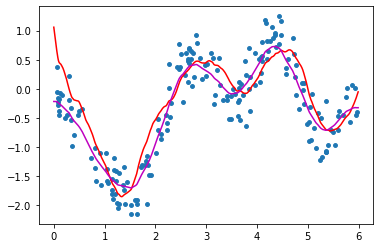

In [17]:
plt.scatter(X, Y, s=15)
print(model.elbo((X,Y)))
Xtest = np.arange(0.0, 6.0, 0.01).reshape(-1, 1)
wideXtest = np.arange(-15.0, 15.0, 0.01).reshape(-1, 1)

modelMean = model.predict_f( Xtest )[0]
exactPosteriorMean = exactModel.predict_f( Xtest )[0]

plt.plot(Xtest, modelMean, color='r')
plt.plot(Xtest, exactPosteriorMean, color='m')
plt.show()

#Testing whether $q(u) = p(u)$ when we fix $q^{1/2}$ = cholesky($K_{uu}$)

In [0]:
def testPriorEqualsPosterior():
  M = 200
  model = gpflow.models.SVGP(
      kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable 
  )
  model.q_sqrt = tf.reshape( tf.linalg.cholesky( Kuu_matern12_RVFF_1D(model.inducing_variable, model.kernel) ), (-1, M, M) )
  
  return model

priorModel = testPriorEqualsPosterior()

tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(True, shape=(), dtype=bool)
tf.Tensor(815677.2535469946, shape=(), dtype=float64)


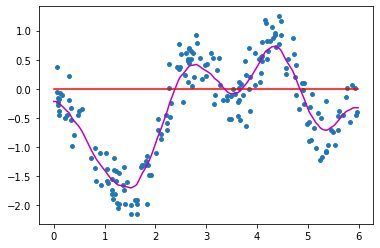

In [52]:
plt.scatter(X, Y, s=15)
Xtest = np.arange(0.0, 6.0, 0.01).reshape(-1, 1)
# wideXtest = np.arange(-12.0, 12.0, 0.01).reshape(-1, 1)

modelMean = priorModel.predict_f( Xtest )[0]
exactPosteriorMean = exactModel.predict_f( Xtest )[0]
# priorMean = constrainedModel.mean_function(Xtest)

print( tf.reduce_all(priorModel.q_sqrt - tf.reshape( tf.linalg.cholesky( Kuu_matern12_RVFF_1D(model.inducing_variable, model.kernel) ), (-1, 200, 200) ) == 0 ) ) 
print( tf.reduce_all(priorModel.q_mu == 0 )  )
print( priorModel.prior_kl() )

# plt.plot(Xtest, priorMean, color='g')
plt.plot(Xtest, modelMean, color='r')
plt.plot(Xtest, exactPosteriorMean, color='m')
plt.show()